## 📊 Exploratory Data Analysis – Top Cancer Counties
This section visualizes the top 10 counties in California with the highest estimated number of cancer incidents.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind

In [27]:
# Load Cancer Dataset
df_cancer = pd.read_csv("data/cleaned/cleaned_cancer_dataset.csv")
print("Cancer Dataset Shape:", df_cancer.shape)
print(df_cancer.head(), "\n")

Cancer Dataset Shape: (1581, 6)
    county     Sex    Cancer   PopTot   AAIR  Cancer_Incidents
0  Alameda    Male  Prostate  4150512   91.9       3814.320528
1  Alameda  Female  Prostate  4209494    0.0          0.000000
2  Alameda    Male    Breast  4150512    1.2         49.806144
3  Alameda  Female    Breast  4209494  125.4       5278.705476
4  Alameda    Male      Lung  4150512   37.8       1568.893536 



In [28]:
cancer_by_county = df_cancer.groupby("county")["Cancer_Incidents"].sum().reset_index()
cancer_by_county = cancer_by_county.sort_values(by="Cancer_Incidents", ascending=False)
cancer_by_county.head(10)

,county,Cancer_Incidents
18,Los Angeles,328954.194195
36,San Diego,126090.400276
29,Orange,116167.866615
32,Riverside,84958.205861
35,San Bernardino,76842.957563
42,Santa Clara,66480.395872
33,Sacramento,57176.611038
0,Alameda,55744.659744
14,Kern,49368.177760
6,Contra Costa,42710.638806


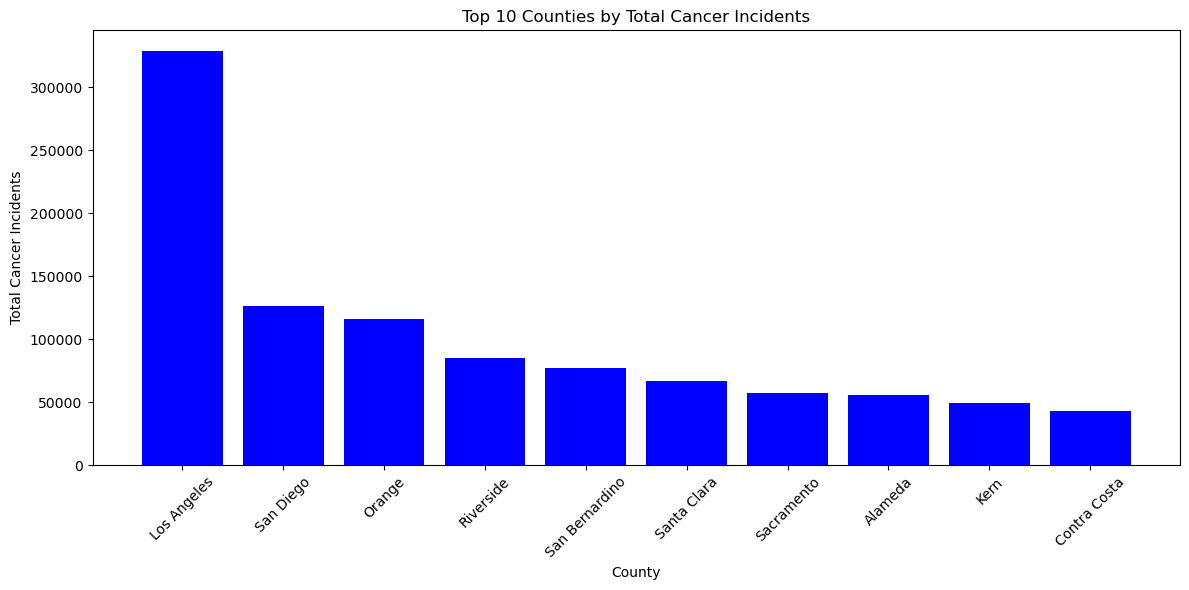

In [29]:
plt.figure(figsize=(12, 6))
plt.bar(
    cancer_by_county["county"][:10],
    cancer_by_county["Cancer_Incidents"][:10],
    color="blue"
)
plt.xlabel("County")
plt.ylabel("Total Cancer Incidents")
plt.title("Top 10 Counties by Total Cancer Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observation:
- Large urban counties (e.g., Los Angeles, San Diego, Orange, Riverside, San Bernardino) rank highest.  
- This likely reflects population size, as these regions have more residents.

## 🔬 PFAS vs Cancer Rate – Hypothesis Testing
This section explores whether higher PFAS levels are associated with increased cancer rates (AAIR) across California counties.

In [36]:
df_pfas = pd.read_csv("data/cleaned/cleaned_pfas.csv")
print("PFAS Dataset Shape:", df_pfas.shape)
print("Columns:", df_pfas.columns, "\n")
print(df_pfas.head(), "\n")

PFAS Dataset Shape: (3654, 41)
Columns: Index(['county', 'gm_samp_collection_date', '10:2FTS', '11ClPF3OUDS',
       '3:3FTCA', '4:2FTS', '5:3FTCA', '6:2FTS', '7:3FTCA', '8:2FTS',
       '9ClPF3ONS', 'ADONA', 'ETFOSA', 'ETFOSE', 'HFPA-DA', 'MEFOSA', 'MEFOSE',
       'NETFOSAA', 'NMEFOSAA', 'PFBSA', 'PFBTA', 'PFDOA', 'PFDSA', 'PFHA',
       'PFHPA', 'PFHPSA', 'PFHXDA', 'PFHXSA', 'PFNA', 'PFNDCA', 'PFNS', 'PFOA',
       'PFODA', 'PFOS', 'PFOSA', 'PFPA', 'PFPES', 'PFTEDA', 'PFTRIDA',
       'PFUNDCA', 'total_pfas_concentration'],
      dtype='object') 

    county gm_samp_collection_date   10:2FTS  11ClPF3OUDS   3:3FTCA    4:2FTS  \
0  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
1  Alameda              2018-11-28  1.200595     1.120463  1.658471  2.179993   
2  Alameda              2018-12-04  1.200595     1.120463  1.658471  2.179993   
3  Alameda              2019-01-02  1.819467     1.106416  1.161811  0.937471   
4  Alameda              2019-01-22  1.

In [38]:
if "total_pfas_concentration" in df_pfas.columns:
    df_pfas.rename(columns={"total_pfas_concentration": "Total_PFAS"}, inplace=True)
else:
    pfas_chemicals = df_pfas.columns[2:]  # adjust if first 2 columns are 'county', 'gm_samp_collection_date'
    df_pfas["Total_PFAS"] = df_pfas[pfas_chemicals].sum(axis=1, skipna=True)

pfas_by_county = df_pfas.groupby("county")["Total_PFAS"].mean().reset_index()
pfas_by_county.columns = ["county", "Avg_PFAS"]

merged_df = pd.merge(df_cancer, pfas_by_county, on="county", how="inner")
print("Merged dataset columns:", merged_df.columns)
print(merged_df.head())

Merged dataset columns: Index(['county', 'Sex', 'Cancer', 'PopTot', 'AAIR', 'Cancer_Incidents',
       'Avg_PFAS'],
      dtype='object')
    county     Sex    Cancer   PopTot   AAIR  Cancer_Incidents    Avg_PFAS
0  Alameda    Male  Prostate  4150512   91.9       3814.320528  152.954981
1  Alameda  Female  Prostate  4209494    0.0          0.000000  152.954981
2  Alameda    Male    Breast  4150512    1.2         49.806144  152.954981
3  Alameda  Female    Breast  4209494  125.4       5278.705476  152.954981
4  Alameda    Male      Lung  4150512   37.8       1568.893536  152.954981


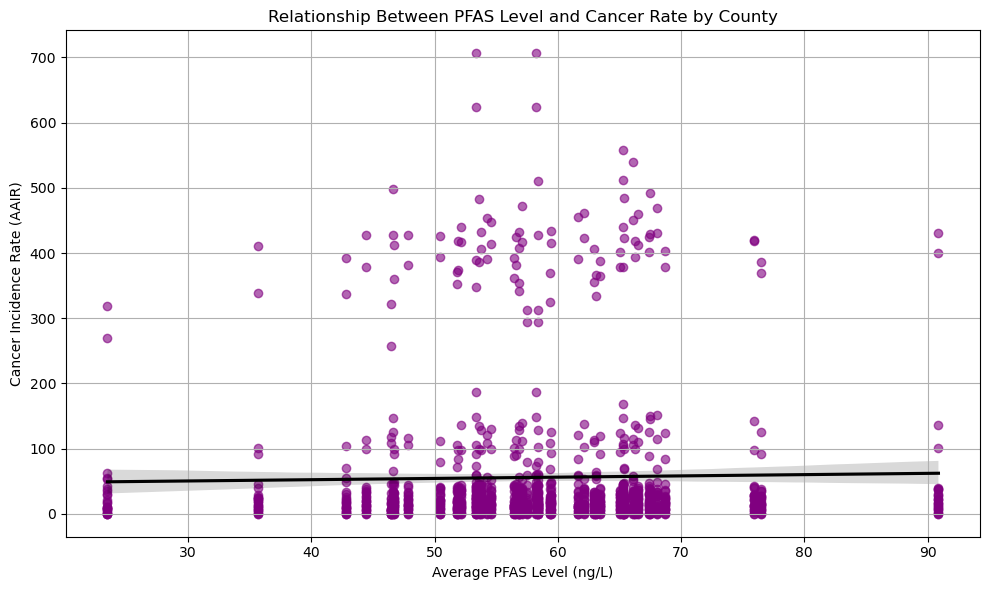

In [33]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged_df, 
    x="Avg_PFAS", 
    y="AAIR",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "black"},
    color = "purple"
)
plt.xlabel("Average PFAS Level (ng/L)")
plt.ylabel("Cancer Incidence Rate (AAIR)")
plt.title("Relationship Between PFAS Level and Cancer Rate by County")
plt.grid(True)
plt.tight_layout()
plt.show()

Hypothesis: Counties with higher PFAS will exhibit higher cancer rates (AAIR). If the scatter plot and regression line do not reveal a clear upward trend, our hypothesis might not hold.


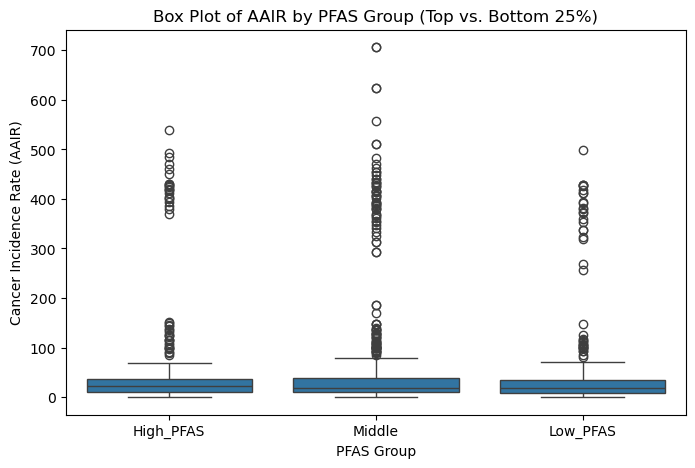

T-test between High_PFAS and Low_PFAS counties:
  t-statistic = 0.821, p-value = 0.412


In [39]:
# 6. Identify top and bottom quartile counties by Avg_PFAS
pfas_sorted = merged_df.groupby("county")["Avg_PFAS"].mean().reset_index()
pfas_sorted.sort_values("Avg_PFAS", ascending=False, inplace=True)

n_counties = len(pfas_sorted)
top_25_cutoff = int(n_counties * 0.25)
bottom_25_cutoff = int(n_counties * 0.25)

top_25_counties = pfas_sorted["county"].head(top_25_cutoff).tolist()
bottom_25_counties = pfas_sorted["county"].tail(bottom_25_cutoff).tolist()

# 7. Label each county in merged_df
merged_df["PFAS_Group"] = "Middle"
merged_df.loc[merged_df["county"].isin(top_25_counties), "PFAS_Group"] = "High_PFAS"
merged_df.loc[merged_df["county"].isin(bottom_25_counties), "PFAS_Group"] = "Low_PFAS"

# 8. Box Plot: AAIR by PFAS group
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x="PFAS_Group", y="AAIR")
plt.title("Box Plot of AAIR by PFAS Group (Top vs. Bottom 25%)")
plt.xlabel("PFAS Group")
plt.ylabel("Cancer Incidence Rate (AAIR)")
plt.show()

# 9. T-test
high_group = merged_df.loc[merged_df["PFAS_Group"]=="High_PFAS","AAIR"]
low_group  = merged_df.loc[merged_df["PFAS_Group"]=="Low_PFAS","AAIR"]

t_stat, p_val = ttest_ind(high_group, low_group, nan_policy='omit')
print("T-test between High_PFAS and Low_PFAS counties:")
print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")


## 📉 Data Interpretation

Scatter Plot:
- The trendline is nearly flat, indicating no strong linear relationship between Avg_PFAS and AAIR.
- Some counties have high PFAS but relatively low AAIR, others have low PFAS but moderate AAIR.

Box Plot/T-Test:
- Comparing the top 25% (High_PFAS) to bottom 25% (Low_PFAS) yields a t-statistic around 0.821 and p-value ~0.412.  
- This high p-value (> 0.05) suggests no statistically significant difference in AAIR between High_PFAS and Low_PFAS counties.
    
At the county level, PFAs alone does not explain variance in cancer rates. Other factors such as genetics, healthcare access, income, and long-term exposure likely play a significant role.

## 📊 Machine Learning
To probe potential non-linear or complex relationships, we tested a simple Random Forest regressor against a baseline model.

In [35]:
# Example: Using Avg_PFAS + PopTot to predict AAIR
merged_df["Population"] = merged_df["PopTot"]  # or rename appropriately
features = ["Avg_PFAS", "Population"]
target = "AAIR"

X = merged_df[features].fillna(0)
y = merged_df[target].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline: mean
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = mean_squared_error(y_test, baseline_pred, squared=False)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb_rmse = mean_squared_error(y_test, y_pred_gb, squared=False)

print("Baseline RMSE:", round(baseline_rmse, 3))
print("Random Forest RMSE:", round(rf_rmse, 3))
print("Gradient Boosting RMSE:", round(gb_rmse, 3))


C:\Users\zuhay_xe4gjlw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\zuhay_xe4gjlw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Baseline RMSE: 102.933
Random Forest RMSE: 111.055
Gradient Boosting RMSE: 108.188


C:\Users\zuhay_xe4gjlw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 📉 Data Interpretation

- Baseline RMSE = 102.933: This represents a naive approach of guessing the mean AAIR for every county.
- Random Forest RMSE = 111.055 and Gradient Boosting RMSE = 108.188: Both are higher than the baseline, indicating that using just*PFAS + population offers no improvement (in fact, it’s worse).

Implications:
1. PFAS levels and population alone do not sufficiently predict county cancer rates.
2. We likely need additional features (e.g., healthcare access, socioeconomic data, age distributions).
3. The lack of strong correlation or predictive power further supports the idea that cancer incidence is multifactorial—PFAS alone cannot explain it.

Next Steps:
- Incorporate more variables (income, education, environment).  
- Consider geospatial analysis with real-time well usage data.  
- Evaluate whether other modeling techniques (or a significantly expanded feature set) can reduce RMSE below baseline.

